# Imports and Functions

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from osgeo import gdal

import os
import glob
import random

from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import rmse, psnr, uqi, ergas, scc, rase, sam, vifp

In [2]:
#gloabl variables
global channels 
channels = ['Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2']

In [88]:
# Functions
def get_rgb(img):
    """Return normalized RGB channels from sentinal image"""
    
    rgb_img = img[:, :, [3,2,1]]
    rgb_normalize = np.clip(rgb_img/10000, 0, 0.3)/0.3
    
    return rgb_normalize

def load_test(path):
    """Returns sentinal image, rgb image and label"""
    
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)
    rgb_img = get_rgb(stack_img)
    
    label_path = path.replace("images","labels").replace("image","label")
    label = gdal.Open(label_path).ReadAsArray()
    
    return stack_img, rgb_img, label

    
def channel_filter(img,c=0):
    """Returns given channel from image"""
    img = np.array(img)
    c_img = img[:, :, c]

    return c_img


def plot_channels(img,invert=False,path=None):
    
    """Plot all channels of a given image"""
    
    global channels

    fig, axs = plt.subplots(3,4,figsize=(15,10))

    index = 0
    for i in range(3):
        for j in range(4):
            c_img = channel_filter(img,c=index)
            if invert:
                c_img = 255-c_img

            axs[i,j].imshow(c_img,cmap='gray')
            axs[i,j].set_title(channels[index],size=20)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

            index +=1

    if path != None:
        plt.savefig(path)

# Get input and labels

In [5]:
test_path = glob.glob("../../data/SWED/test/images/*")
print(test_path[0])
print(len(test_path))

# Load all images
input = []
rgb = []
labels = []

for path in test_path:
    try:
        img, rgb_img, label = load_test(path)
    
        input.append(img)
        labels.append(label)
        rgb.append(rgb_img)
    except:
        print("Error with image: ", path)

# Apply canny to binary maps
canny_input = [np.uint8(img*255) for img in labels]
edge_reference = [np.uint8(cv2.Canny(img,threshold1 = 100, threshold2 = 200)) for img in canny_input]

../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif
98


In [6]:
#Sense checks
print("Lengths:",len(input), len(labels), len(rgb), len(edge_reference))

print("Input:", np.min(input[0]),np.max(input[0]))
print("RGB:", np.min(rgb[0]),np.max(rgb[0]))
print(len(rgb[0][0][0]))
print("Labels:",np.min(labels[0]),np.max(labels[0]))
print("Edge reference:",np.min(edge_reference),np.max(edge_reference))


Lengths: 98 98 98 98
Input: 66 8625
RGB: 0.05 1.0
3
Labels: 0 1
Edge reference: 0 255


61


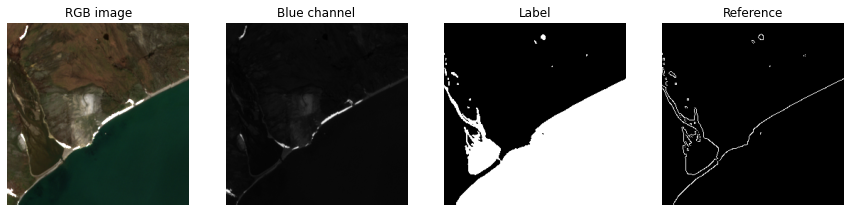

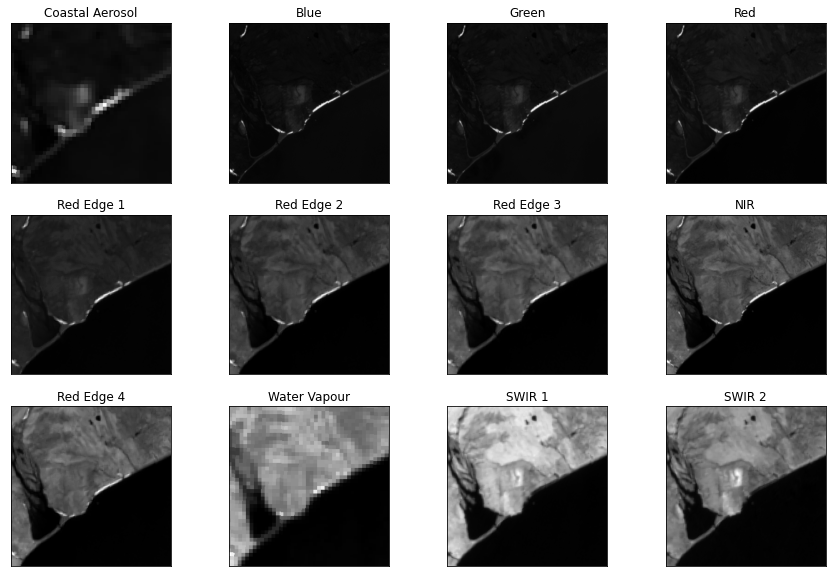

In [10]:
# View an image 
rint = random.randint(0,98)
print(rint)

fig, axs = plt.subplots(1,4, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")
axs[0].axis("off")

axs[1].imshow(input[rint][:,:,1],cmap="gray")
axs[1].set_title("Blue channel")
axs[1].axis("off")

axs[2].imshow(labels[rint],cmap="gray")
axs[2].set_title("Label")
axs[2].axis("off")

axs[3].imshow(edge_reference[rint],cmap="gray")
axs[3].set_title("Reference")
axs[3].axis("off")

plot_channels(input[rint])

# Edge detection

In [19]:
def preprocess(img_input, toggle=[True,True,True]):
        """Preprocess image for edge detection
        toggle: [Equalized histogram, Gaussian blur, Morphological closing]
        """
        img = img_input.copy()
        img = np.array(img)

        # Iterate over bands
        for i in range(12):
                img_i = img[:,:,i]

                # Scale bands between 0 and 255
                img[:,:,i] = cv2.normalize(img[:,:,i], None, 0, 255, cv2.NORM_MINMAX)

                # Equalized histogram
                img_i = np.uint8(img_i)
                if toggle[0]:
                        img_i = cv2.equalizeHist(img_i)


                # Gaussian blur
                if toggle[1]:
                        kernel = (5, 5)
                        img_i = cv2.GaussianBlur(img_i, kernel,0)

                # Morphological closing
                if toggle[2]:
                        kernel = np.ones((5,5),np.uint8)
                        img_i = cv2.morphologyEx(img_i, cv2.MORPH_CLOSE, kernel)
                
                img[:,:,i] = img_i
       
        img = np.uint8(img)
        return img

def canny_ed(img_input, threshold1=100, threshold2=200):

    #Apply canny edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        img_i = cv2.Canny(img_i,threshold1 = threshold1, threshold2 = threshold2)
        img[:,:,i] = img_i

    return img


def scharr_ed(img_input):
    #Apply scharr edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        schx = cv2.Scharr(img_i, cv2.CV_8U,1,0)
        schy = cv2.Scharr(img_i, cv2.CV_8U,0,1)
        scharr_img = schx + schy

        img[:,:,i] = scharr_img

    return img

def sobel_ed(img_input):
    #Apply sobel edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        sobelx = cv2.Sobel(img_i, cv2.CV_8U,1,0,ksize=5)
        sobely = cv2.Sobel(img_i, cv2.CV_8U,0,1,ksize=5)
        sobel_img = sobelx + sobely

        img[:,:,i] = sobel_img

    return img    

def prewitt_ed(img_input):
    #Apply prewitt edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        kx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]]) 
        ky = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
        prewittx = cv2.filter2D(img_i, -1, kx)
        prewitty = cv2.filter2D(img_i, -1, ky)
        prewitt_img = prewittx + prewitty

        img[:,:,i] = prewitt_img

    return img

In [91]:
# Preprocess images
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

# Apply edge detection
canny = [canny_ed(img) for img in preprocess_input]
scharr = [scharr_ed(img) for img in preprocess_input]
sobel = [sobel_ed(img) for img in preprocess_input]
prewitt = [prewitt_ed(img) for img in preprocess_input]

15


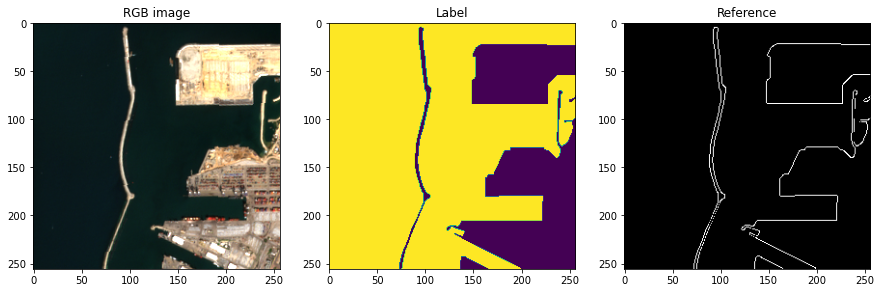

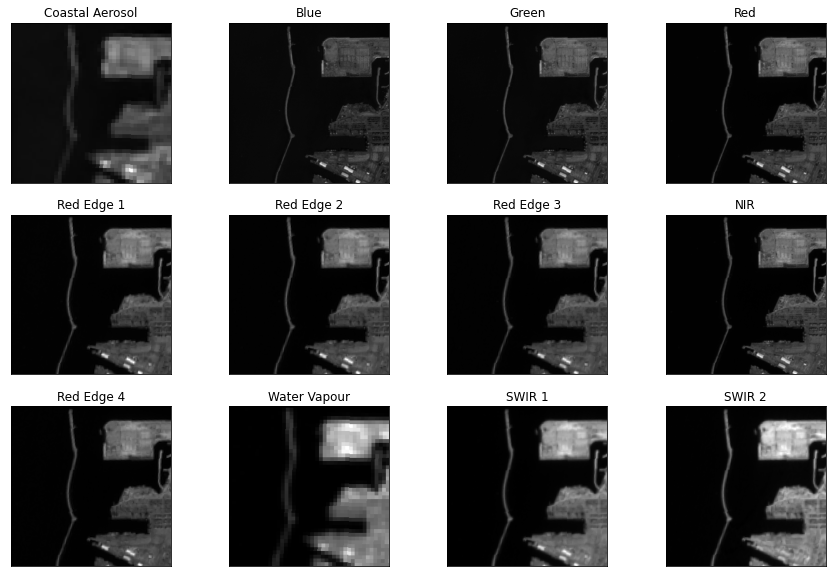

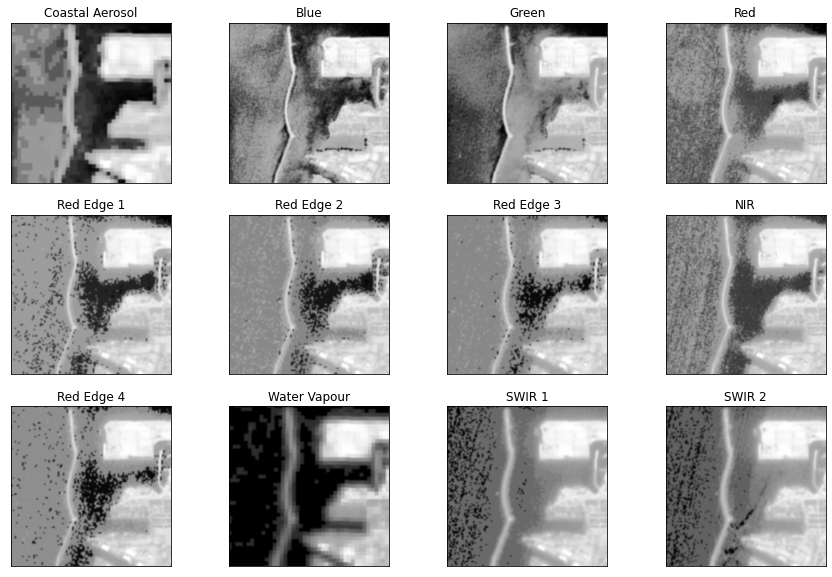

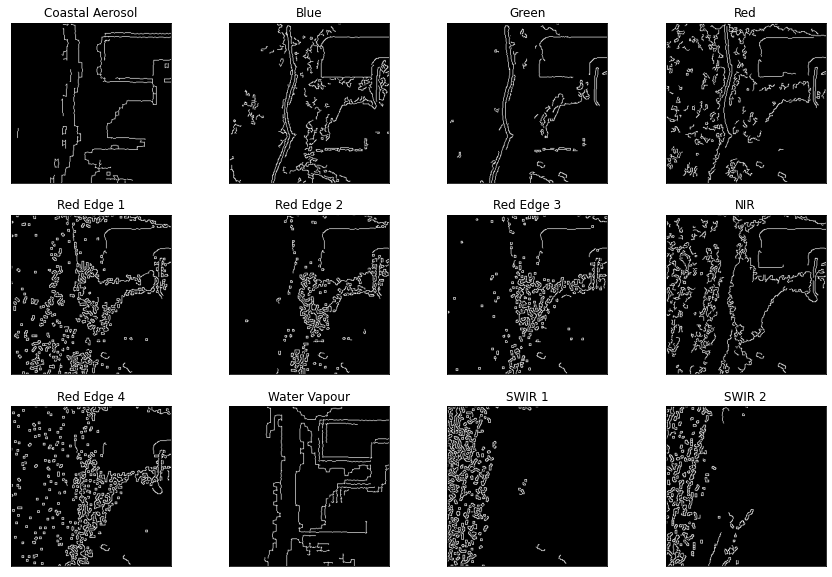

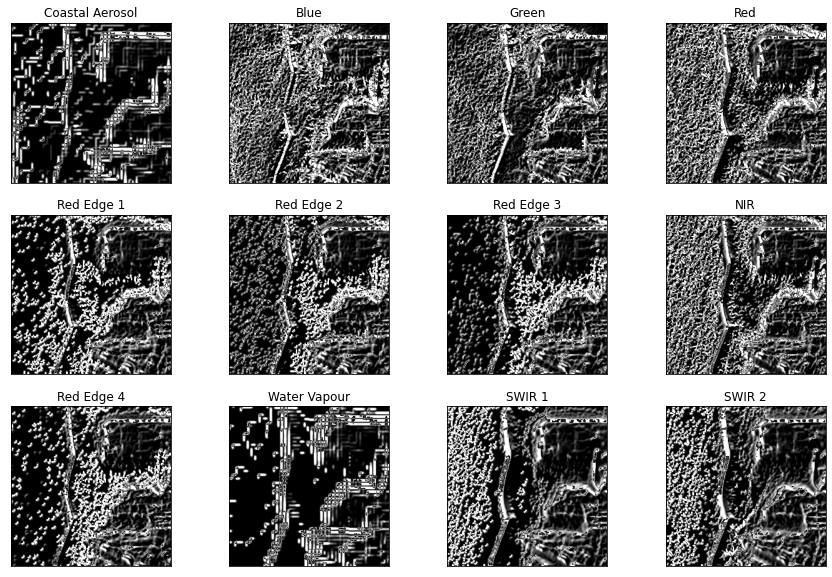

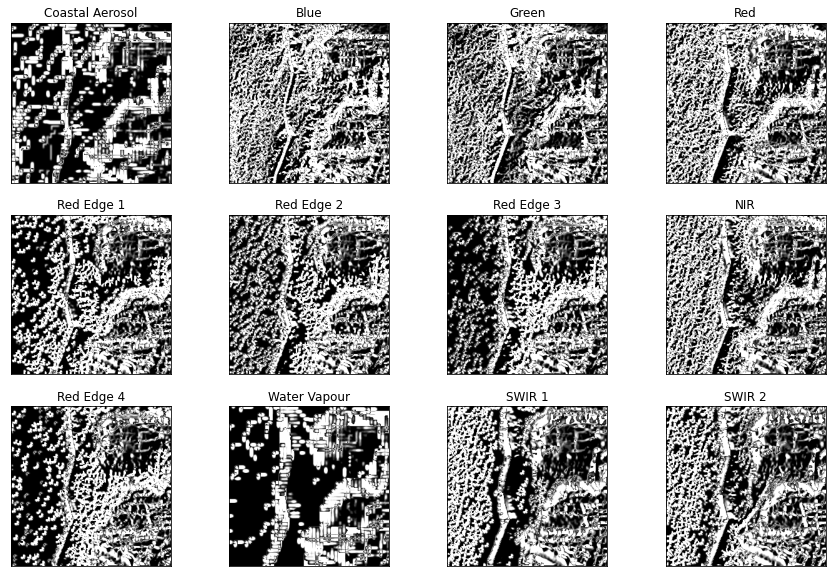

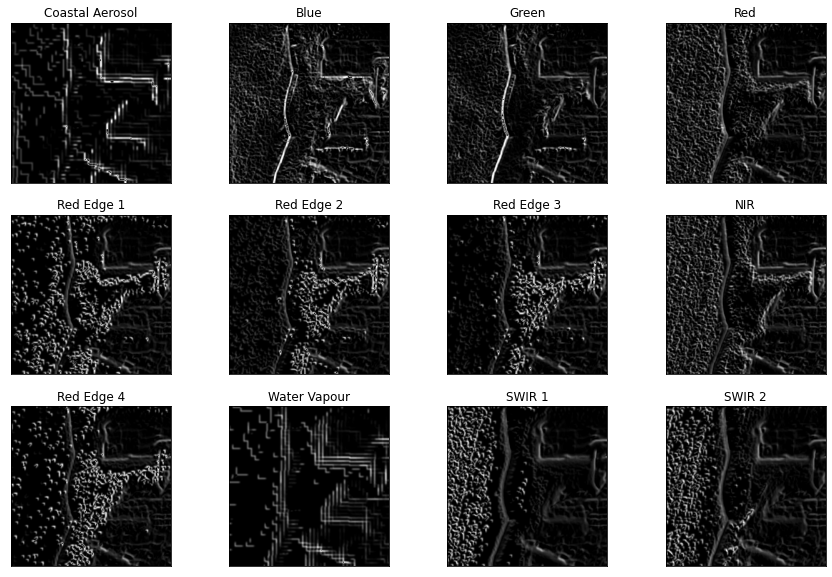

In [19]:
# Visualize edge detection
rint = random.randint(0,98)
print(rint)
fig, axs = plt.subplots(1,3, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")

axs[1].imshow(labels[rint])
axs[1].set_title("Label")

axs[2].imshow(edge_reference[rint],cmap="gray")
axs[2].set_title("Reference")

plot_channels(input[rint])

plot_channels(preprocess_input[rint])

plot_channels(canny[rint])

plot_channels(scharr[rint])

plot_channels(sobel[rint])

plot_channels(prewitt[rint])

# Calculate Metrics

In [333]:
def metrics(toggle=[True,True,False]):
    """Calculate metrics
    toggle: [Equalized histogram, Gaussian blur, Morphological closing]"""

    preprocess_input = input.copy()
    preprocess_input = [preprocess(img,toggle=toggle) for img in preprocess_input]

    canny = [canny_ed(img) for img in preprocess_input]
    scharr = [scharr_ed(img) for img in preprocess_input]
    sobel = [sobel_ed(img) for img in preprocess_input]
    prewitt = [prewitt_ed(img) for img in preprocess_input]

    rows = []
    for i in range(len(edge_reference)):
        ref_img = edge_reference[i]
        ID = "IMG#{}".format(i)
        
        for j in range(12):

            for method in ['canny','sobel','scharr','prewitt']:

                if method == 'canny':
                    img = canny[i][:,:,j]
                elif method == 'sobel':
                    img = sobel[i][:,:,j]
                elif method == 'scharr':
                    img = scharr[i][:,:,j]
                elif method == 'prewitt':
                    img = prewitt[i][:,:,j]

                rmse_ = rmse(ref_img,img)
                psnr_ = psnr(ref_img,img)
                uqi_ = uqi(ref_img,img)
                ssim_ = ssim(ref_img,img,multichannel=True)
                ergas_ = ergas(ref_img,img)
                scc_ = scc(ref_img,img)
                sam_ = sam(ref_img,img)
                vifp_ = vifp(ref_img,img)

                row = [ID,j+1,method,rmse_,psnr_,uqi_,ssim_,ergas_,scc_,sam_,vifp_]
                rows.append(row)
        
    df_metrics = pd.DataFrame(rows,columns = ['ID',"band","method","rmse","psnr","uqi","ssim","ergas","scc","sam","vifp"])
    return df_metrics

In [326]:
# With equalized histogram, Gaussian blur
df_metrics = metrics()
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_84017/1040344002.py:31: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)
/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/sewar/full_ref.py:270: RuntimeWarning: invalid value encountered in double_scalars
  val = np.clip(np.dot(GT[:,i],P[:,i]) / (np.linalg.norm(GT[:,i])*np.linalg.norm(P[:,i])),-1,1)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   62.840807  12.165969  0.606168  0.760107   
1  IMG#0     1    sobel  154.552187   4.349301  0.062504  0.158585   
2  IMG#0     1   scharr  102.114954   7.949017  0.073042  0.202906   
3  IMG#0     1  prewitt   54.809723  13.353651  0.055752  0.287388   
4  IMG#0     2    canny   97.066768   8.389392  0.357720  0.521368   

          ergas       scc       sam      vifp  
0  22712.453428  0.001426  1.496065  0.012186  
1  42514.164666 -0.000064  1.441654  0.007732  
2  29509.822791  0.000234  1.451558  0.008626  
3  20174.602050  0.001567  1.464869  0.009523  
4  26452.212029  0.014886  1.420190  0.031005

In [334]:
# With equalized histogram, Morphological closing
df_metrics = metrics(toggle=[True,False,True])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_84017/4050410403.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   78.286885  10.257023  0.444999  0.632948   
1  IMG#0     1    sobel  147.054056   4.781263  0.088116  0.246596   
2  IMG#0     1   scharr  103.471134   7.834419  0.122093  0.365272   
3  IMG#0     1  prewitt   61.374303  12.371072  0.093555  0.385970   
4  IMG#0     2    canny   80.184000  10.049049  0.425889  0.636895   

          ergas       scc       sam      vifp  
0  26399.071577  0.000255  1.494533  0.010702  
1  40682.576640  0.001299  1.456060  0.006613  
2  30328.993795 -0.001436  1.485564  0.006651  
3  21775.060833 -0.001278  1.488072  0.008312  
4  24738.362800  0.011679  1.406753  0.035201

In [335]:
# With equalized histogram
df_metrics = metrics(toggle=[True,False,False])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_84017/4050410403.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   78.829981  10.196975  0.442986  0.629021   
1  IMG#0     1    sobel  147.485521   4.755816  0.087121  0.244223   
2  IMG#0     1   scharr  103.898240   7.798640  0.119916  0.362653   
3  IMG#0     1  prewitt   61.508375  12.352119  0.088245  0.379766   
4  IMG#0     2    canny  120.193478   6.533186  0.190313  0.341794   

          ergas       scc       sam      vifp  
0  26765.284653  0.000463  1.492990  0.010928  
1  40777.945583  0.002370  1.455997  0.006744  
2  30477.751751 -0.001305  1.484598  0.006823  
3  21831.701325 -0.001043  1.487631  0.008333  
4  31953.298014  0.023167  1.417124  0.029726

In [336]:
# With gaussian blur
df_metrics = metrics(toggle=[False,True,False])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_84017/4050410403.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   48.277161  14.455969  0.736069  0.851022   
1  IMG#0     1    sobel  126.553173   6.085343  0.068628  0.186666   
2  IMG#0     1   scharr   83.056050   9.743378  0.083111  0.256971   
3  IMG#0     1  prewitt   46.352833  14.809278  0.051093  0.416612   
4  IMG#0     2    canny   48.256604  14.459668  0.735006  0.852225   

          ergas       scc       sam      vifp  
0  19456.218528  0.000904  1.552568  0.000829  
1  34414.622144  0.000069  1.451816  0.007570  
2  24514.757680 -0.000421  1.480485  0.006798  
3  18397.852162  0.001301  1.496469  0.007490  
4  18876.509366  0.002060  1.546719  0.000148

# Visualise metrics

In [103]:
def metric_bar(df,metric,save=False):
    """Plot bar chart of given metric for each edge detection method and band"""
    global channels 

    fig,ax = plt.subplots(1,1,figsize=(15,5))

    mean = df.groupby(["method","band"],as_index=False).mean()
    sd = df.groupby(["method","band"],as_index=False).std()

    edge_methods = ["canny","sobel","scharr","prewitt"]
    for i,em in enumerate(edge_methods):

        bands = mean[mean["method"]==em]["band"]
        em_mean = mean[mean["method"]==em][metric]
        em_sd = sd[sd["method"]==em][metric]

        w = 0.4
        plt.bar(bands-w/2+i*w/2,em_mean,yerr=em_sd,width=w/2,label=em)


    plt.ylabel(metric.upper(),fontsize=20)
    plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

    plt.legend()
    if save:
        plt.savefig("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/figures/{}_BAR.png".format(metric),bbox_inches='tight')

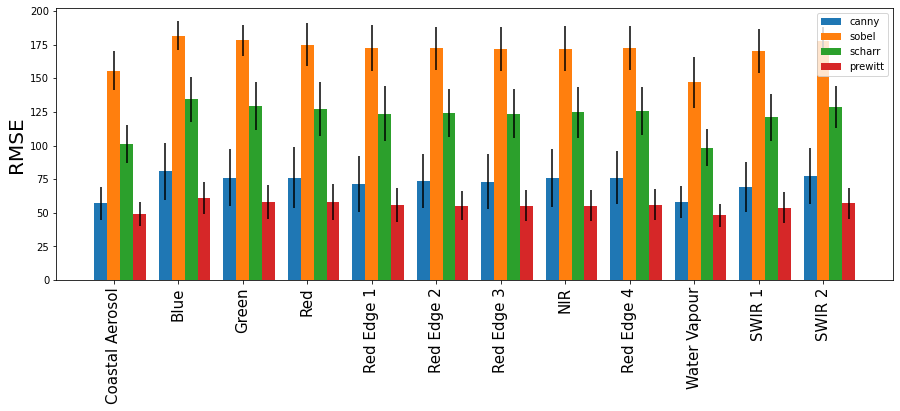

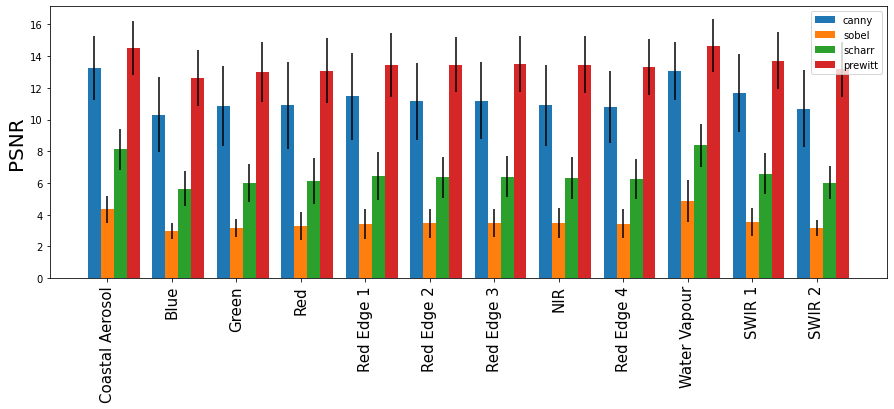

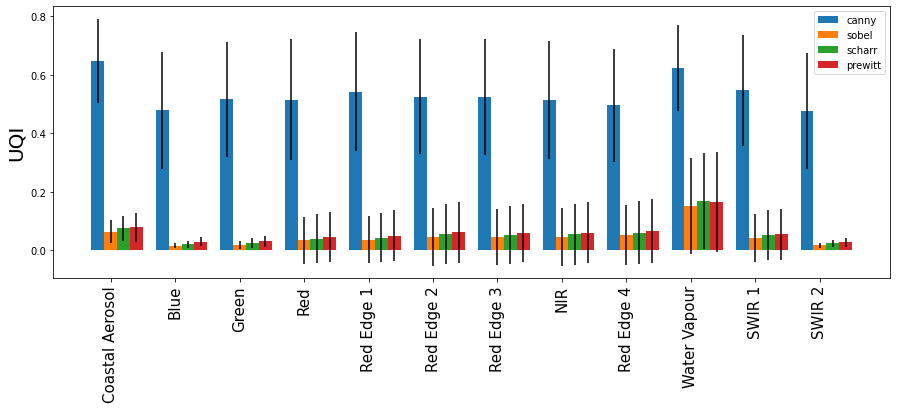

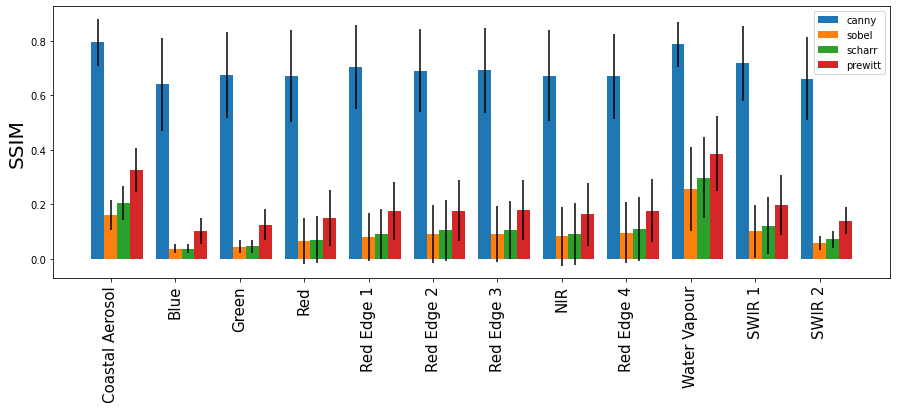

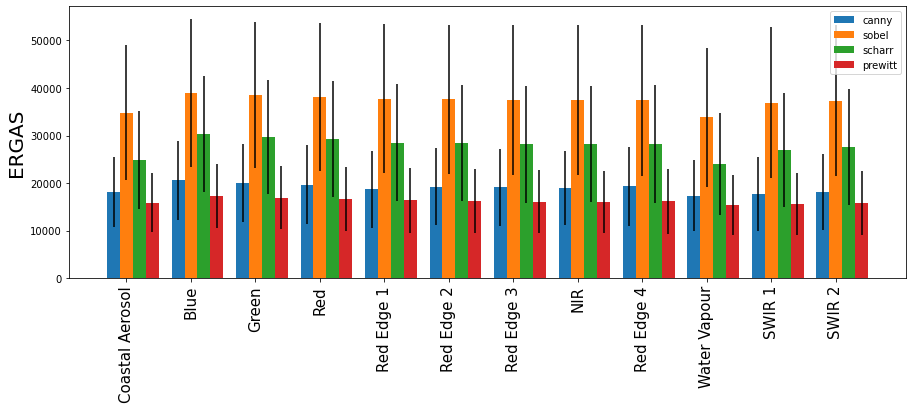

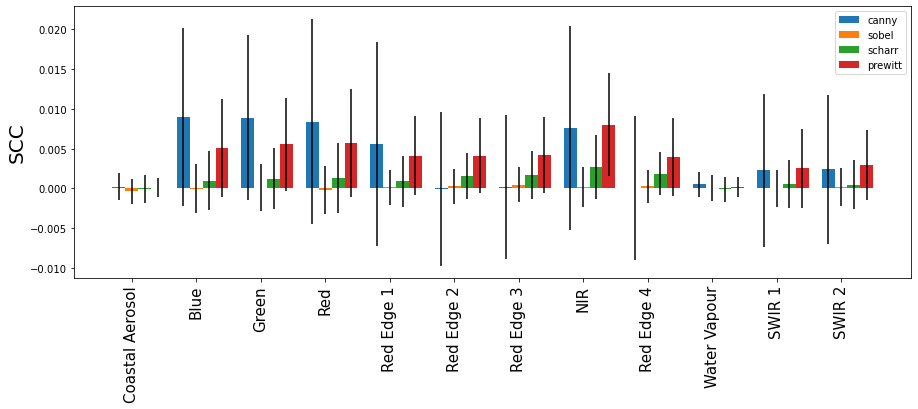

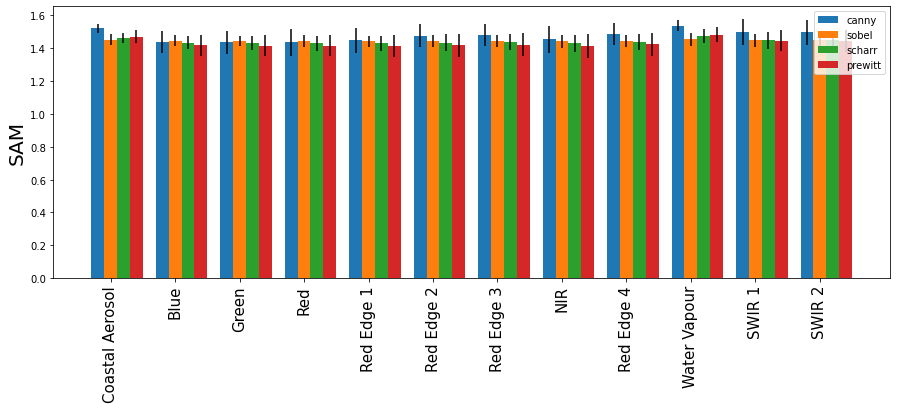

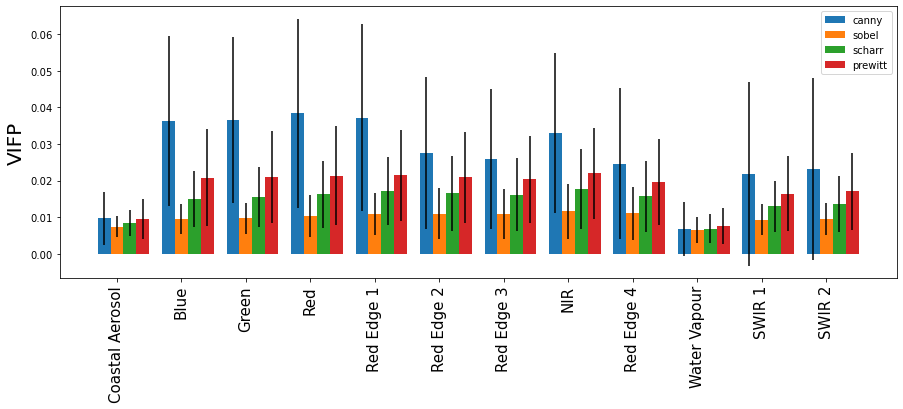

In [104]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0)

metric_bar(df_metrics,'rmse',save=True)
metric_bar(df_metrics,'psnr',save=True)
metric_bar(df_metrics,'uqi')
metric_bar(df_metrics,'ssim',save=True)
metric_bar(df_metrics,'ergas')
metric_bar(df_metrics,'scc')
metric_bar(df_metrics,'sam',save=True)
metric_bar(df_metrics,'vifp')

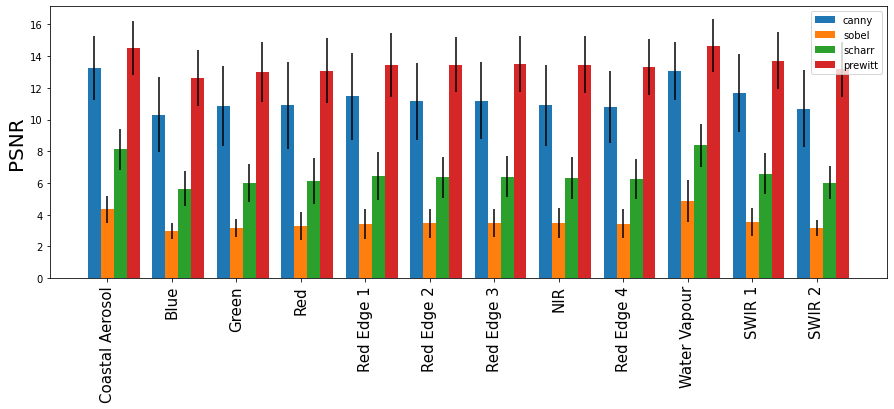

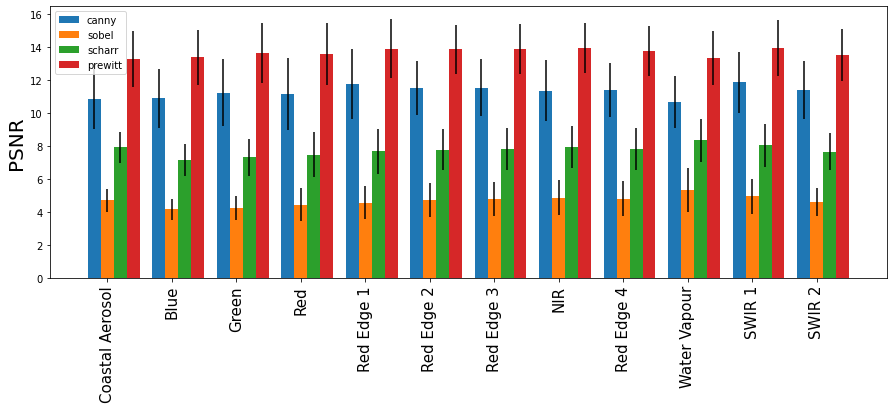

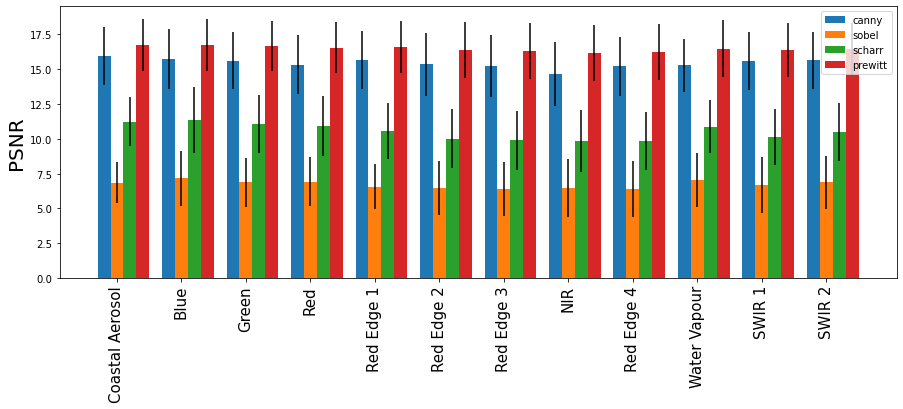

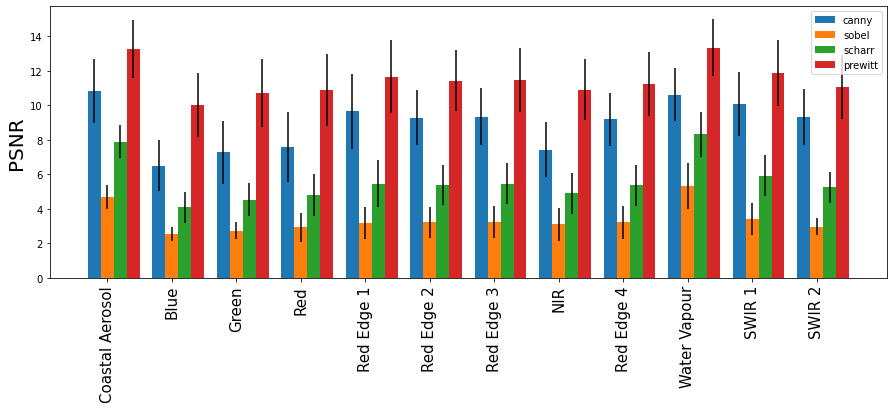

In [443]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist.csv",index_col=0)
metric_bar(df_metrics,'psnr')


# Figures for paper 

In [12]:
save_path = "/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/figures/{}"

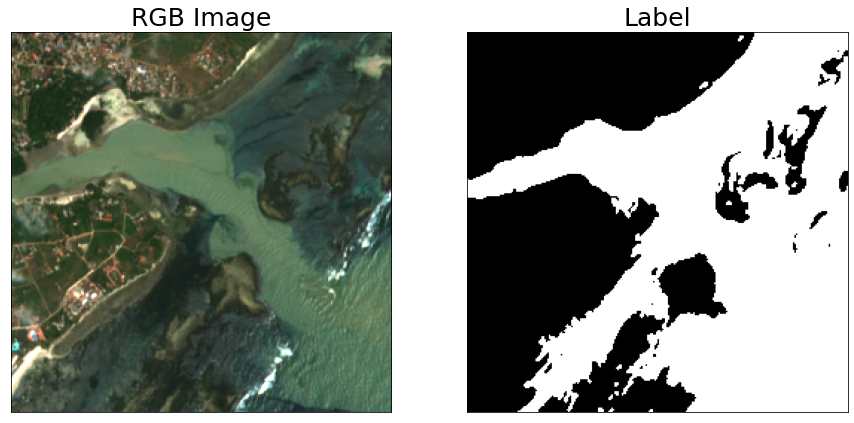

In [14]:
#Fig. 1. Example of a test image and label
rint = 90
fig, axs = plt.subplots(1,2, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB Image",size=25)

axs[1].imshow(labels[rint],cmap="gray")
axs[1].set_title("Label",size=25)
rint +=1

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("text_example"),bbox_inches='tight')

98


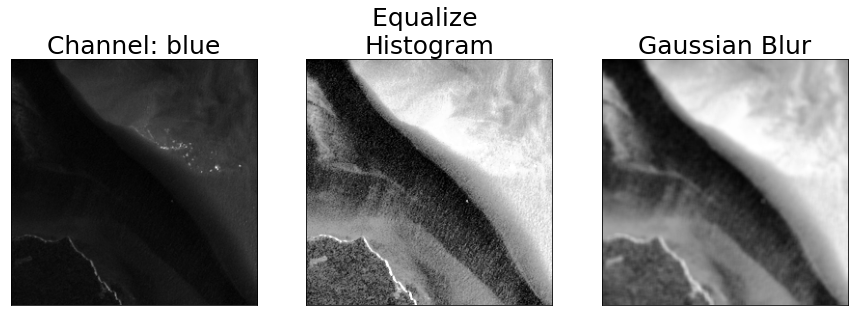

In [17]:
#Fig. 2. Example of pre-processing steps using blue band
rint = random.randint(0,98)
fig, axs = plt.subplots(1,3, figsize=(15,15))
print(rint)
rint = 2

#Get blue channel
img = channel_filter(input[rint],c=1)

# Original
axs[0].imshow(img,cmap="gray")
axs[0].set_title("Channel: blue",size=25)

# Scale bands between 0 and 255
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img = np.uint8(img)

# Histogram Equalization
img = cv2.equalizeHist(img)
axs[1].imshow(img,cmap="gray")
axs[1].set_title("Equalize \nHistogram",size=25)

# Gaussian Blur
kernel = (5,5)
img = cv2.GaussianBlur(img, kernel,cv2.BORDER_DEFAULT)
axs[2].imshow(img,cmap="gray")
axs[2].set_title("Gaussian Blur",size=25)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("preprocessing.png"),bbox_inches='tight')

42


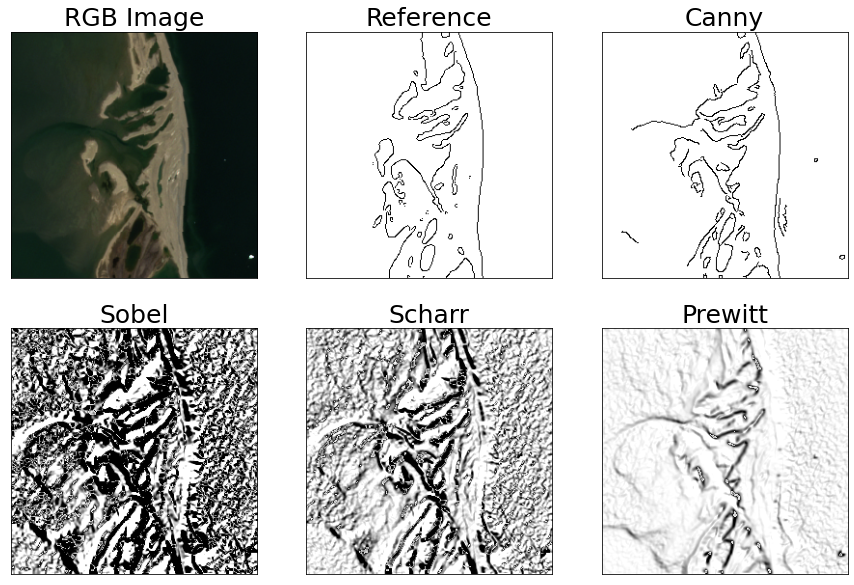

In [94]:
#Fig. 3. Edge detection algorithms applied to blue band
rint = random.randint(0,98)
fig, axs = plt.subplots(2,3, figsize=(15,10))
print(rint)
rint = 7

channel = 1

axs[0,0].imshow(rgb[rint])
axs[0,0].set_title("RGB Image",size=25)

axs[0,1].imshow(255-edge_reference[rint],cmap="gray")
axs[0,1].set_title("Reference",size=25)

axs[0,2].imshow(255-canny[rint][:,:,channel],cmap="gray")
axs[0,2].set_title("Canny",size=25)

axs[1,0].imshow(255-sobel[rint][:,:,channel],cmap="gray")
axs[1,0].set_title("Sobel",size=25)

axs[1,1].imshow(255-scharr[rint][:,:,channel],cmap="gray")
axs[1,1].set_title("Scharr",size=25)

axs[1,2].imshow(255-prewitt[rint][:,:,channel],cmap="gray")
axs[1,2].set_title("Prewitt",size=25)

for ax1 in axs:
    for ax in ax1:
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig(save_path.format("edge_detection.png"),bbox_inches='tight')

0


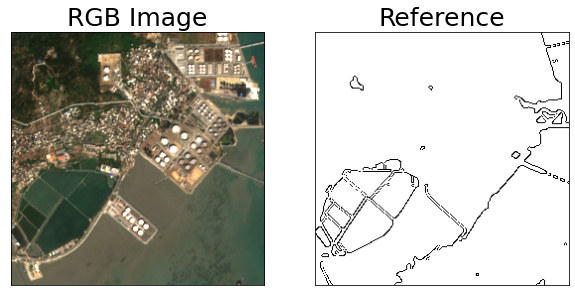

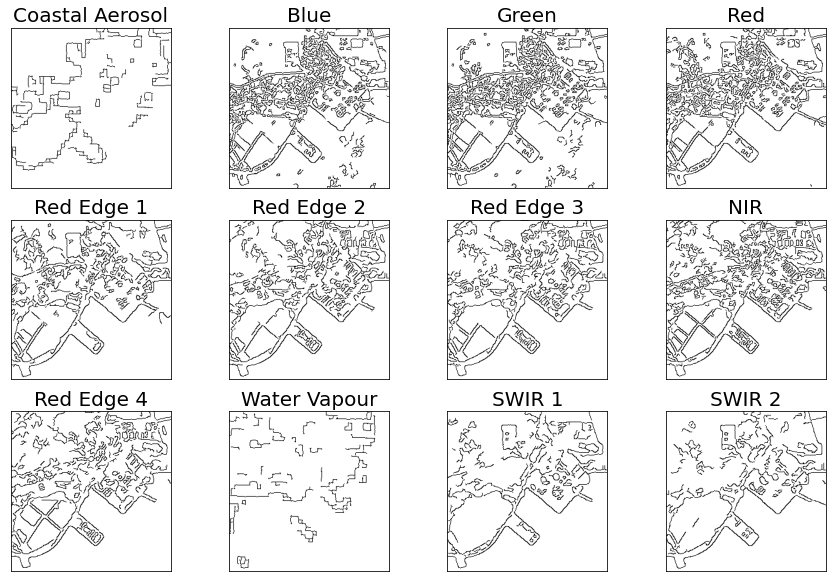

In [95]:
# Fig. 4. Image with non-coastal edges
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

canny = [canny_ed(img) for img in preprocess_input]

rint = 0
fig, axs = plt.subplots(1,2, figsize=(10,15))
print(rint)

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB Image",size=25)

axs[1].imshow(255-edge_reference[rint],cmap="gray")
axs[1].set_title("Reference",size=25)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("details.png"),bbox_inches='tight')

#Fig. 5. Edge detection applied to all channels
plot_channels(canny[rint],invert=True,path=save_path.format("canny_all.png"))

In [114]:
# Table 1: Metrics for all images
# Create in excel
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0)

mean_all = df_metrics.groupby(["method","band"],as_index=False).mean()

all_stats = mean_all[mean_all["method"]=="canny"][['psnr',"ssim"]]
all_stats.columns = ['canny_psnr_mn',"canny_ssim_mn"]

for method in ["sobel","scharr","prewitt"]:
    all_stats[method+"_psnr_mn"] = np.array(mean_all[mean_all["method"]==method]["psnr"])
    all_stats[method+"_ssim_mn"] = np.array(mean_all[mean_all["method"]==method]["ssim"])

std_all = df_metrics.groupby(["method","band"],as_index=False).std()

for method in ["canny","sobel","scharr","prewitt"]:
    all_stats[method+"_psnr"] = np.array(std_all[std_all["method"]==method]["psnr"])
    all_stats[method+"_ssim"] = np.array(std_all[std_all["method"]==method]["ssim"])

all_stats.to_clipboard()

In [110]:
mean_all[mean_all["method"]==method]["psnr"]

12    14.480591
13    12.610174
14    13.016054
15    13.090303
16    13.428662
17    13.446458
18    13.484834
19    13.460146
20    13.331072
21    14.648407
22    13.702719
23    13.168520
Name: psnr, dtype: float64

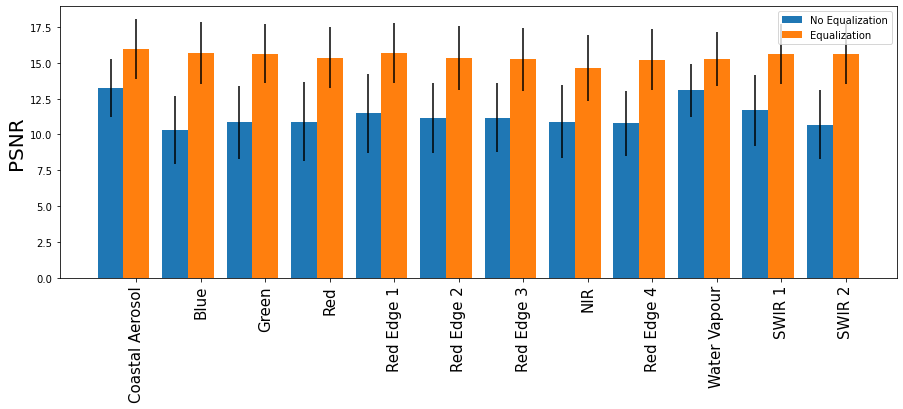

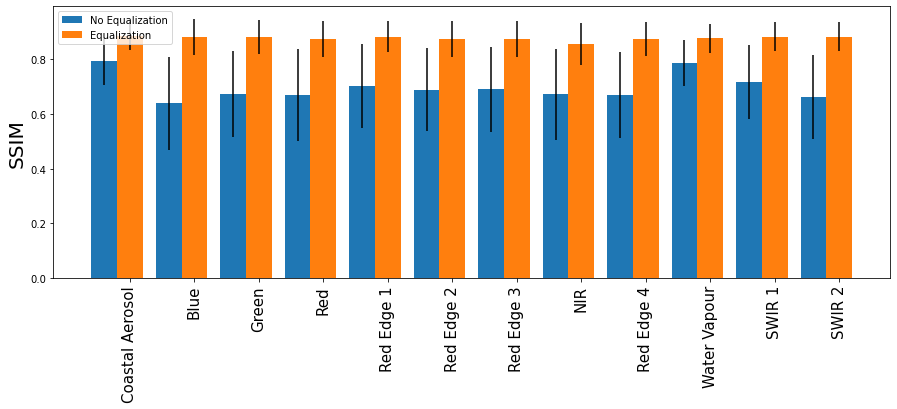

In [96]:
#Fig. 8. Average PSNR for Canny edge detection with and without histogram equalization

# Compare histogram equalization vs no equalization
df_all = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0)
df_blur = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur.csv",index_col=0)
df_morph = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph.csv",index_col=0)

mean_all = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_all = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_blur = df_blur[df_blur.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_blur = df_blur[df_blur.method=='canny'].groupby(["method","band"],as_index=False).std()


bands = mean_all['band']

w= 0.8
metric = 'psnr'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_all[metric],yerr=sd_all[metric],width=w/2,label='No Equalization')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Equalization')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend()
plt.savefig(save_path.format("equalization_effect.png"),bbox_inches='tight')

w= 0.8
metric = 'ssim'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_all[metric],yerr=sd_all[metric],width=w/2,label='No Equalization')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Equalization')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend()

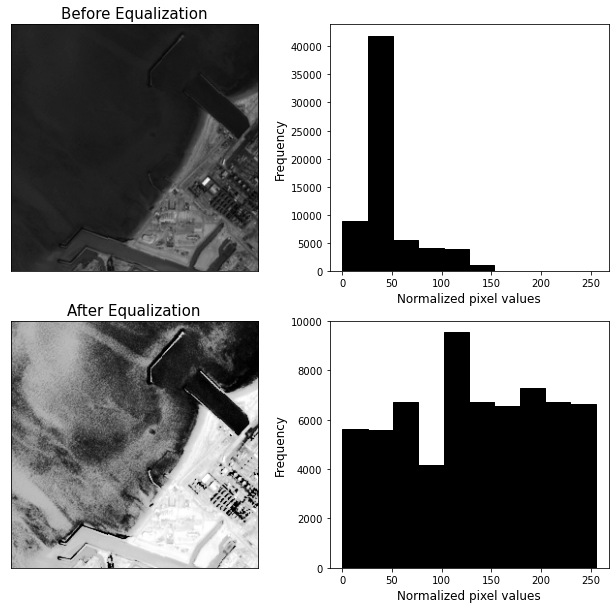

In [428]:
fig, axs = plt.subplots(2,2, figsize=(11,10))
rint= 60

#Before equalization
blue = channel_filter(input[rint],1)
blue = cv2.normalize(blue, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
axs[0,0].imshow(blue,cmap="gray")

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title("Before Equalization",size=15)

axs[0,1].hist(blue.ravel(), fc='k', ec='k')
axs[0,1].set_xlabel("Normalized pixel values",size=12)
axs[0,1].set_ylabel("Frequency",size=12)

#After equalization
blue_hist = cv2.equalizeHist(blue)
axs[1,0].imshow(blue_hist,cmap="gray")
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
axs[1,0].set_title("After Equalization",size=15)

axs[1,1].hist(blue_hist.ravel(), fc='k', ec='k')
axs[1,1].set_xlabel("Normalized pixel values",size=12)
axs[1,1].set_ylabel("Frequency",size=12)

plt.savefig(save_path.format("histogram_equalization.png"),bbox_inches='tight')

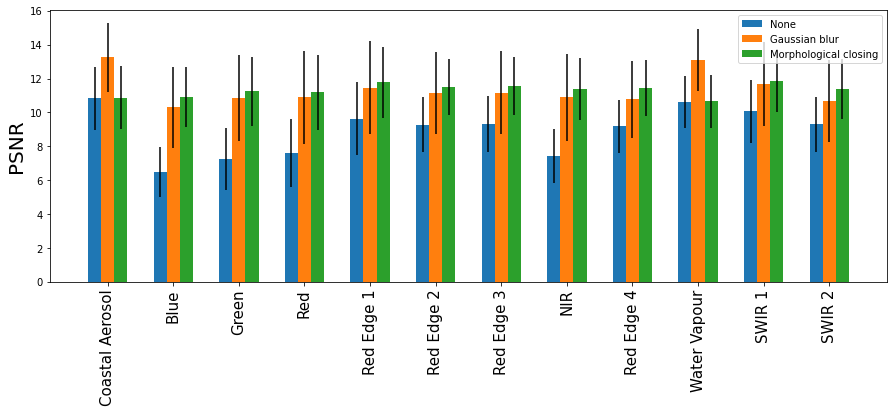

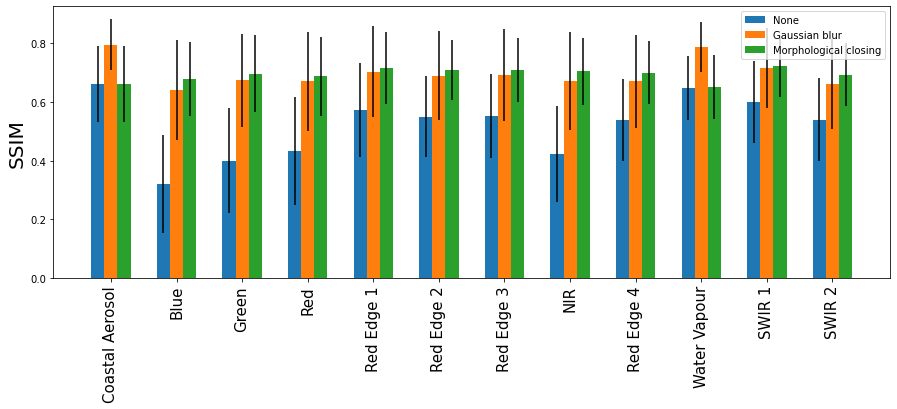

In [98]:
#Fig. 10. Average PSNR for canny edge detection using different noise reduction methods

# Determin impact of post processing
df_hist = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist.csv",index_col=0) #no noise reduction
df_all = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0) #blur
df_morph = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph.csv",index_col=0) #morph

mean_none = df_hist[df_hist.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_none = df_hist[df_hist.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_blur = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_blur = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_morph = df_morph[df_morph.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_morph = df_morph[df_morph.method=='canny'].groupby(["method","band"],as_index=False).std()

bands = mean_none['band']

w= 0.4
metric = 'psnr'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_none[metric],yerr=sd_none[metric],width=w/2,label='None')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Gaussian blur')
plt.bar(bands+w/2,mean_morph[metric],yerr=sd_morph[metric],width=w/2,label='Morphological closing')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend()

plt.savefig(save_path.format("effect_processing.png"),bbox_inches='tight')

w= 0.4
metric = 'ssim'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_none[metric],yerr=sd_none[metric],width=w/2,label='None')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Gaussian blur')
plt.bar(bands+w/2,mean_morph[metric],yerr=sd_morph[metric],width=w/2,label='Morphological closing')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend()

# Archive

In [ ]:
# Thresholding and preprocessing experiments 
thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
#toggles = [[True,False,False],[True,True,False],[True,False,True],[True,True,True]]
toggles = [[True,True,False]]

rows = []

for toggle in toggles:
    print(toggle)
    preprocess_input = input.copy()
    preprocess_input = [preprocess(img,toggle=toggle) for img in preprocess_input]

    for threshold in thresholds:
        print(threshold)

        t1 = threshold[0]
        t2 = threshold[1]
        canny = [canny_ed(img,threshold1=t1,threshold2=t2) for img in preprocess_input]
        
        for i in range(len(edge_reference)):
            ref_img = edge_reference[i]
            ID = "IMG#{}".format(i)
            
            for j in range(12):
                
                img = canny[i][:,:,j]

                rmse_ = rmse(ref_img,img)
                psnr_ = psnr(ref_img,img)
                uqi_ = uqi(ref_img,img)
                ssim_ = ssim(ref_img,img,multichannel=True)
                """ergas_ = ergas(ref_img,img)
                scc_ = scc(ref_img,img)
                sam_ = sam(ref_img,img)
                vifp_ = vifp(ref_img,img)"""

                row = [ID,str(threshold),str(toggle),j+ 1,rmse_,psnr_,uqi_,ssim_]
                rows.append(row)

    
df_metrics = pd.DataFrame(rows,columns = ['ID',"thresholds","toggle","band","rmse","psnr","uqi","ssim"])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_canny.csv")
df_metrics.head()

In [ ]:
mean =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).mean()
sd =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).std()
metric = "psnr"
global channels

thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
toggles = [[True,False,False],[True,True,False],[True,False,True],[True,True,True]]


fig,ax = plt.subplots(1,1,figsize=(15,5))

w = 0.4
for i,thresh in enumerate(thresholds):

    bands = mean[mean.thresholds==str(thresh)]["band"]

    mean_i = mean[mean.thresholds==str(thresh)][metric]
    sd_i = sd[sd.thresholds==str(thresh)][metric]
    
    plt.bar(bands-w/3+i*w/3,mean_i,yerr=sd_i,width=w/3,label=str(thresh))

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend(title="Thresholds")


In [ ]:
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

rint = random.randint(0,98)
print(rint)
rint=48
fig, axs = plt.subplots(1,3, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")

axs[1].imshow(labels[rint],cmap="gray")
axs[1].set_title("Label")

axs[2].imshow(255-edge_reference[rint],cmap="gray")
axs[2].set_title("Reference")


fig,axs = plt.subplots(2,3,figsize=(15,10))

for i,ax in enumerate(axs.flatten()):
    t1 = thresholds[i][0]
    t2 = thresholds[i][1]
    canny = [canny_ed(img,t1,t2) for img in preprocess_input][rint][:,:,1]
    psnr_ = psnr(edge_reference[rint],canny)
    ax.imshow(255-canny,cmap="gray")
    ax.set_title("Thresholds=({},{}) PSNR={:.2f}".format(t1,t2,psnr_))

In [ ]:
rint = random.randint(0,98)
print(rint)


preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]


r = edge_reference[rint]*1.0
print(r.min(),r.max())

c = 2
canny = [canny_ed(img) for img in preprocess_input][rint][:,:,c]*1.0
print(canny.min(),canny.max())

non_edge =  np.array(canny)-np.array(r)
non_edge = np.clip(non_edge,0,255)
print(non_edge.min(),non_edge.max())

edge = np.clip(non_edge,0,255)-np.array(canny)
print(edge.min(),edge.max())

fig, axs = plt.subplots(1,5, figsize=(15,15))

axs[0].imshow(rgb[rint])

axs[1].imshow(255-r,cmap="gray")
axs[1].set_title("Reference")
axs[2].imshow(255-canny,cmap="gray")
axs[2].set_title("Canny Edge Detection")
axs[3].imshow(255-non_edge,cmap="gray")
axs[3].set_title("Not edges")
axs[4].imshow(edge,cmap="gray")
axs[4].set_title("Edges")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])